<a href="https://colab.research.google.com/github/fayisode/Essential-Cryptography-for-JavaScript-Developers/blob/main/Copy_of_FastAISwahiliSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install huggingface_hub["fastai"] -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
! git clone https://github.com/ohmeow/blurr.git

Cloning into 'blurr'...
remote: Enumerating objects: 5397, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (360/360), done.
remote: Total 5397 (delta 895), reused 1140 (delta 837), pack-reused 4173
Receiving objects: 100% (5397/5397), 36.45 MiB | 30.13 MiB/s, done.
Resolving deltas: 100% (4126/4126), done.


In [ ]:
%cd /content/blurr

/content/blurr


In [ ]:
!pip install -e ".[dev]" -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 73.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta

In [ ]:
!pip install transformers

In [ ]:
!pip install jax

In [ ]:
import torch
import transformers
from fastai.text.all import *


from blurr.text.data.all import *
from blurr.text.modeling.all import *

In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [ ]:
random_seed(2023,True)

In [ ]:
import fastai
fastai.__version__

'2.7.12'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def to_sentiment(rating):
    rating = int(rating)
    if rating == -1:
        return 'Negative'
    elif rating == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [ ]:
def train_model(pretrained_model_name, cycle):
  train = pd.read_csv("/content/Train.csv")
  train['Labels'] = train.Labels.apply(to_sentiment)
  n_labels = len(train["Labels"].unique())
  model_cls = transformers.AutoModelForSequenceClassification
  # pretrained_model_name = "Davlan/xlm-roberta-base-finetuned-swahili"
  config = transformers.AutoConfig.from_pretrained(pretrained_model_name)
  config.num_labels = n_labels

  hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
      pretrained_model_name,
      model_cls=model_cls,
      config=config
  )
  blocks = (
      TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
      CategoryBlock
  )

  # The datablock
  dblock = DataBlock(
      blocks=blocks,
      get_x=ColReader("Tweets"),
      get_y=ColReader("Labels"),
      splitter=TrainTestSplitter(0.05, stratify=train["Labels"]))

  # Creating the dataloader.
  dls = dblock.dataloaders(train, bs=4)
  dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)
  model = BaseModelWrapper(hf_model)
  learn = Learner(
      dls,
      hf_model,
      opt_func=partial(Adam, decouple_wd=True),
      loss_func=CrossEntropyLossFlat(),
      metrics=[accuracy],
      cbs=[BaseModelCallback],
      splitter=blurr_splitter,
  )

  learn.freeze()
  learn.fit_one_cycle(cycle, lr_max=1e-3)
  learn.lr_find()
  learn.model
  # learn.fine_tune(30)
  return learn

,text,target
0,Ushauri wako ni mchango mkubwa sana kwake 2Tweet mtu napost kitu kama kapost contrnt nzur na umekagua profile ake ako poa kwann usiretweet Mm nilipost kitu nkamfata mtu inbox bas aretweet akaniomba pesa ok its finenkaacahana nae lkn nilivoingia kwa,Positive
1,Hbari MuluzWakala wetu wa Masasi anapatikana kwa 0774212121Pia tunao wawakilishi Nanyumbu 0774212121 Nanyamba 0777080921 Newala 0774212121 Tandahimba 0777080921 Unaweza kutembelea duka letu linapatikana Stendi kuu Karibu Zantel upate hudum,Neutral


epoch,train_loss,valid_loss,accuracy,time
0,0.827682,0.722713,0.666667,00:25
1,0.830231,0.709882,0.666667,00:23
2,0.775987,0.727540,0.657895,00:28
3,0.738893,0.668256,0.710526,00:25
4,0.631409,0.742115,0.710526,00:24
5,0.611108,0.685850,0.701754,00:25
6,0.581415,0.711653,0.692982,00:23
7,0.528911,0.756208,0.719298,00:29
8,0.451166,0.834296,0.684211,00:25
9,0.418349,0.825979,0.710526,00:24


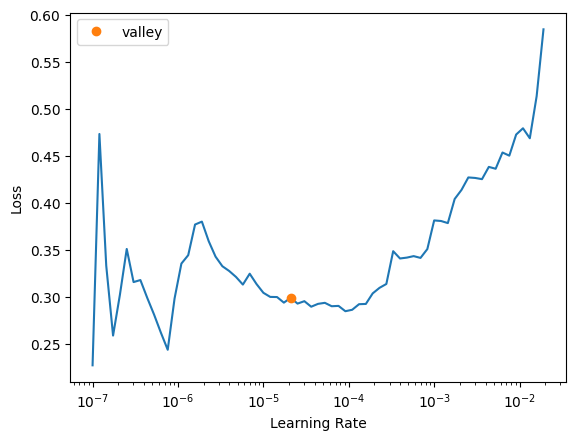

In [ ]:
learn1 = train_model('benjamin/roberta-base-wechsel-swahili',10)

,text,target
0,Je wajua Kiwa Monk huweza kukaa kwenye maji yanayochemka na asiweze kuhisi maumivu Wtafiti mbalimbali wamesema kuwa Monk wanauwezo wa kutuliza miili yao katima maumivu makali na wanaufunza ubongo wao kuvumilia hio hali kupigia Njia ya upumumuaji Medi,Neutral
1,Sichomi chanjo kwasababu Mpk sasacjajua chanjo ipI ni sahihi na ipi si sahihi zipo nying sanaPili bado mda huo autoshi kutoa ufanisi wa chanjo hioTatu imetoa negative impct nying kwa mda mchache kptia expermt tofautdamu kuganda nk,Neutral


epoch,train_loss,valid_loss,accuracy,time
0,0.941986,0.861657,0.640351,00:33
1,0.876935,0.806629,0.552632,00:25
2,0.736282,0.879961,0.605263,00:25
3,0.736178,0.675423,0.640351,00:27
4,0.695815,0.735353,0.675439,00:28
5,0.654130,0.683364,0.666667,00:25
6,0.683925,0.665279,0.666667,00:25
7,0.599134,0.725543,0.666667,00:26
8,0.563416,0.716061,0.666667,00:24
9,0.471637,0.711293,0.649123,00:29


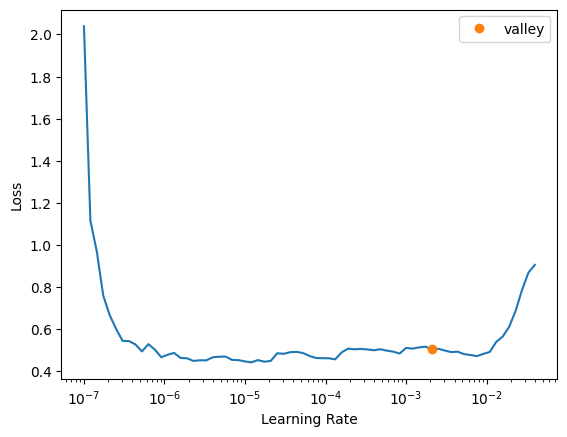

In [ ]:
learn2 = train_model('mbeukman/xlm-roberta-base-finetuned-swahili-finetuned-ner-swahili',10)

,text,target
0,ushauri wako ni mchango mkubwa sana kwake 2tweet mtu napost kitu kama kapost contrnt nzur na umekagua profile ake ako poa kwann usiretweet mm nilipost kitu nkamfata mtu inbox bas aretweet akaniomba pesa ok its finenkaacahana nae lkn nilivoingia kwa a,Positive
1,hbari muluzwakala wetu wa masasi anapatikana kwa 0774212121pia tunao wawakilishi nanyumbu 0774212121 nanyamba 0777080921 newala 0774212121 tandahimba 0777080921 unaweza kutembelea duka letu linapatikana stendi kuu karibu zantel upate hudum,Neutral


epoch,train_loss,valid_loss,accuracy,time
0,0.880865,0.894440,0.578947,00:31
1,0.865758,0.786256,0.596491,00:26
2,0.700539,0.832167,0.587719,00:24
3,0.705943,0.932352,0.570175,00:28
4,0.661988,0.884030,0.596491,00:28
5,0.574191,0.928289,0.570175,00:25
6,0.535384,0.894800,0.605263,00:26
7,0.527190,0.893788,0.614035,00:25
8,0.551378,0.899426,0.605263,00:29
9,0.511017,0.905512,0.596491,00:27


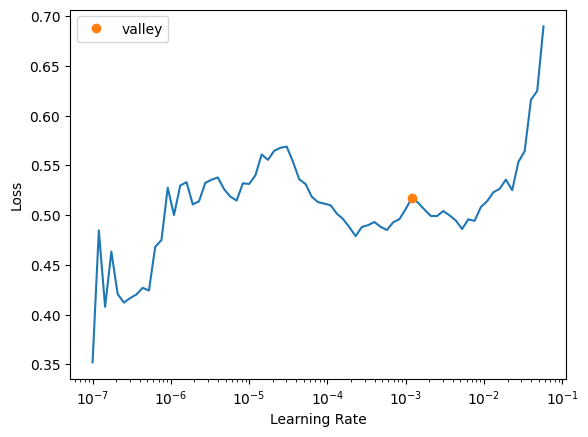

In [ ]:
learn3 = train_model('flax-community/bert-base-uncased-swahili',10)

,text,target
0,Je wajua Kiwa Monk huweza kukaa kwenye maji yanayochemka na asiweze kuhisi maumivu Wtafiti mbalimbali wamesema kuwa Monk wanauwezo wa kutuliza miili yao katima maumivu makali na wanaufunza ubongo wao kuvumilia hio hali kupigia Njia ya upumumuaji Medi,Neutral
1,Viwavijeshi wanapita katika hatua kuu 6 za ukuaji katika hatua yake ya larvae mayai 10001500 hutagwa na larvae mmoja kwa mwezi Hatua pekee inayowezesha kusambaa kwa viwa vijeshi ni kipepeo ambao huruka kwa makundi na wanaweza kuruka hadi kilometa 150,Negative


epoch,train_loss,valid_loss,accuracy,time
0,0.835588,0.798352,0.649123,00:25
1,0.855587,0.837840,0.649123,00:26
2,0.727318,0.805617,0.587719,00:28
3,0.766775,0.808532,0.631579,00:25
4,0.730243,0.736454,0.692982,00:26
5,0.654659,0.806007,0.649123,00:26
6,0.653339,0.801334,0.666667,00:26
7,0.583538,0.808566,0.675439,00:30
8,0.526009,0.826920,0.701754,00:27
9,0.542148,0.828954,0.701754,00:26


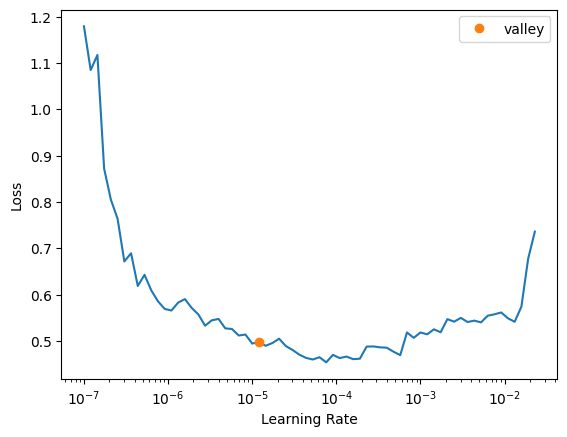

In [ ]:
learn4 = train_model('Davlan/xlm-roberta-base-finetuned-swahili',10)

,text,target
0,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuafu na Msamehe na Mtukuze kushuka kwake kaburini na Upanue kuingia kwake na Muoshe na maji na kwa theluji na barafu na Mtakase na makosa kama Unavyoitakasa nguo nyeupe kutokana na uchafu na Mbadilishie nyum,Positive
1,Vijana kutoka DTBTanzania tawi la Mwanza wakikabidhi mifuko ya Saruji kwa Mhe Stanslaus Mabula Mbunge wa Nyamagana Mwanza jana Huu ulikuwa ni machango wa benki yetu katika kukabiliana na changamoto ya upungufu wa madarasa katika shule za msingi ziliz,Positive


epoch,train_loss,valid_loss,accuracy,time
0,0.911642,0.911205,0.596491,00:38
1,0.820893,0.814692,0.614035,00:41
2,0.743483,0.812254,0.649123,00:29
3,0.718548,0.807185,0.614035,00:25
4,0.765891,0.797831,0.640351,00:27
5,0.682673,0.849598,0.631579,00:27
6,0.577657,0.819169,0.605263,00:26
7,0.570067,0.826138,0.640351,00:26
8,0.548891,0.850279,0.622807,00:29
9,0.501660,0.847043,0.640351,00:27


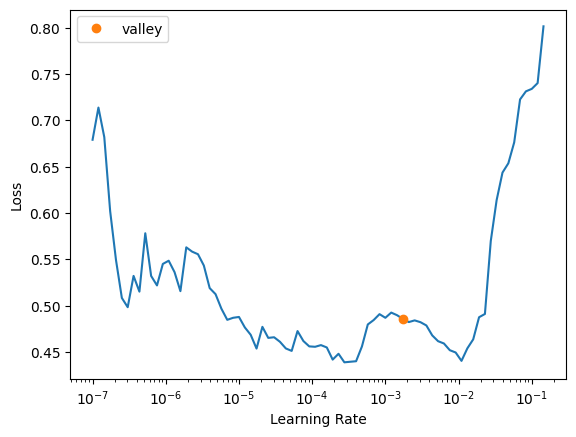

In [ ]:
learn5 = train_model('Davlan/bert-base-multilingual-cased-finetuned-swahili',10)

In [ ]:
def make_test_result(model):
  test = pd.read_csv("/content/Test.csv")
  tdl = model.dls.test_dl(test['Tweets'])
  test_preds_tta, test_labels_tta = model.tta(dl=tdl)
  highest_indices = np.argmax(test_preds_tta, axis=1)
  labels = np.where(highest_indices == 0, -1, highest_indices)
  labels = np.where(highest_indices == 1, 0, labels)
  labels = np.where(highest_indices == 2, 1, labels)
  return labels

def submission_file(labels, location):
  ss = pd.read_csv("/content/sample_submission.csv")
  import os
  submission = ss.copy()
  ss = ss.sort_values(by='ID')
  ss['Labels'] = labels
  ss.to_csv(location,index = False)

In [ ]:
pred1 = make_test_result(learn1)
pred2 = make_test_result(learn2)
pred3 = make_test_result(learn3)
pred4 = make_test_result(learn4)
pred5 = make_test_result(learn5)

In [ ]:
from collections import Counter
all_predictions = [pred1,pred2,pred3,pred4,pred5]
# Create an empty list to store the ensemble predictions
ensemble_predictions = []

# Iterate through the predictions for each example
for i in range(len(pred1)):
    # Count the votes for each label (-1, 0, 1) for this example
    votes = Counter([model[i] for model in all_predictions])

    # Choose the label with the most votes as the ensemble prediction
    ensemble_prediction = votes.most_common(1)[0][0]

    # Append the ensemble prediction to the list
    ensemble_predictions.append(ensemble_prediction)

In [ ]:
submission_file(ensemble_predictions, 'main.csv')